# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | First Name | Last Name | Signature | Hours | Contribution |
| Member 2: | First Name | Last Name | Signature | Hours | Contribution |
| Member 3: | First Name | Last Name | Signature | Hours | Contribution |
| Member 4: | First Name | Last Name | Signature | Hours | Contribution |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

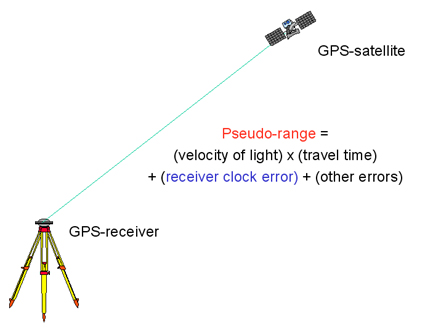

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [ ]:
df_pseudorange = pd.read_excel('pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [ ]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [ ]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [ ]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [ ]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    # Compute euclidean distance (rho)
    rho = euclidean_norm(r_pos, s_pos)

    # Predicted pseudorange
    residuals = pseudorange - rho - cdT

    #calculate sum of squared residuals
    L = np.sum((residuals)**2)/n

    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [ ]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    # Compute euclidean distance (rho)
    rho = euclidean_norm(r_pos, s_pos)

    #compute resiudal to be used in gradient calculation
    residuals = pseudorange - rho - cdT

    # Residuals between observed and predicted pseudorange
    grad = np.array([0.0,0.0,0.0,0.0])

    #calculate gradient
    grad[0] = (2/n)*(np.sum((residuals)*(sat_pos[:,0]-r_pos[0])/rho))   #x gradient
    grad[1] = (2/n)*(np.sum((residuals)*(sat_pos[:,1]-r_pos[1])/rho))   #y gradient
    grad[2] = (2/n)*(np.sum((residuals)*(sat_pos[:,2]-r_pos[2])/rho))   #z gradient
    grad[3] = (-2/n)*(np.sum(residuals))                                #cdT gradient
    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [ ]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=100000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)


        # update estimates
        # (1 mark)
        X_new = X - learning_rate*grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], cdT, s_pos, pseudorange)

        #collect intermediate results for cost and gradients
        arr_cost.append(new_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [ ]:
#call gradient descent function
optimized_params = gradient_descent(pseudorange, sat_pos)

# print the mentioned metrics
print("Optimized parameters:", optimized_params) #final coordinates with cdT correction
print("Final position errors of receiver:", arr_err[-1]) #final error for each of x, y, and z
print("Number of steps taken for convergence:", steps_count) #total number of steps
print("Final cost value:", arr_cost[-1]) #cost value for of final iteration
print("Final gradient values:", arr_grad[-1]) #final gradient corrections for x, y, z, and cdT

Converged !
Optimized parameters: [-1.63349244e+06 -3.65162953e+06  4.95248538e+06  6.44483145e+00]
Final position errors of receiver: [-3.06203979 -2.34427531  3.76521232]
Number of steps taken for convergence: 2941
Final cost value: 0.5634689861474059
Final gradient values: [ 0.00017765  0.00098986 -0.00304226 -0.00172474]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

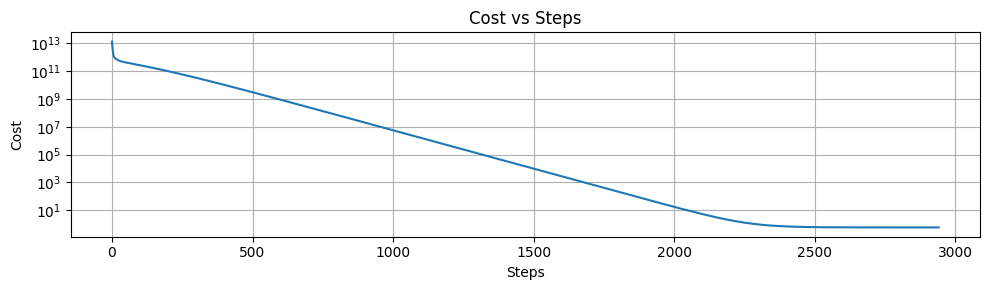

In [ ]:
#creating figure
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))

#applying semilogy to scale y-axis
ax.semilogy(arr_cost)

#setting axis and title
ax.set_xlabel('Steps')
ax.set_ylabel('Cost')
ax.set_title('Cost vs Steps')

ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# Since cost represents the squared sum of our variance between pseudorange and P_hat,
# it will continue decreasing as our approximated value of P_hat approaches the value of pseudorange until the convergance is satisfied

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

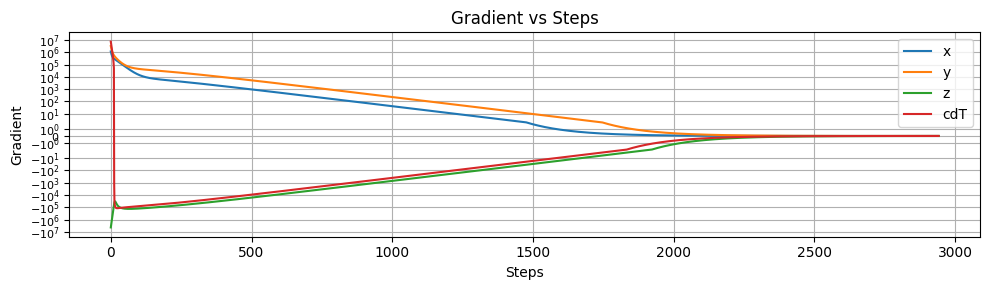

In [ ]:
#creating figure
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))

#applying symlog to y axis scale
ax.set_yscale('symlog')
ax.tick_params(axis='y', labelsize=8)
ax.plot(arr_grad)

#setting axis, legend, and title
ax.set_xlabel('Steps')
ax.set_ylabel('Gradient')
ax.set_title('Gradient vs Steps')
plt.legend(['x', 'y', 'z', 'cdT'])

ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# As the iteration value increases all gradient corrections approach 0.
#This is because as the value of corrected P_hat approaches pseudorange the gradient correction will get smaller and smaller

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

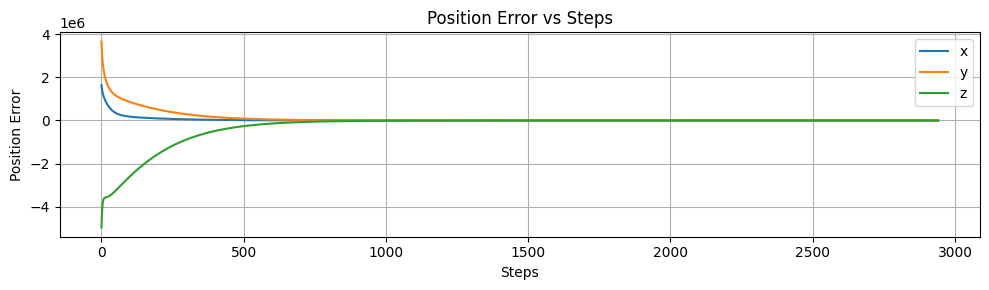

In [ ]:
#creating figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

ax.plot(arr_err)

#setting axis, legend, and title
ax.set_xlabel('Steps')
ax.set_ylabel('Position Error')
ax.set_title('Position Error vs Steps')
plt.legend(['x', 'y', 'z'])

ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# just like for the gradient plot the position errors should incrementaly approach 0,
# this is because our final value for P_hat when it converges should be very close to pseudorange,
# for this to happen the x, y, z positions for r_pos must be approaching the values of GroundTruth.

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [ ]:
#set learning rate to 0.01

#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

#calling gradient descent function with learning rate set to 0.01
optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=0.01)

# print the metrics

print("Optimized parameters:", optimized_params_2) #final x, y, z, and cdT values
print("Final position errors of receiver:", arr_err[-1]) #error for x, y, z positions from final iteration
print("Number of steps taken for convergence:", steps_count) #total iterations
print("Final cost value:", arr_cost[-1]) #cost value from final iteration
print("Final gradient values:", arr_grad[-1]) #gradient values for x, y, z, cdT for final iteration

Converged !
Optimized parameters: [-1.63349244e+06 -3.65162949e+06  4.95248528e+06  6.38703033e+00]
Final position errors of receiver: [-3.05608623 -2.31110222  3.6632575 ]
Number of steps taken for convergence: 27697
Final cost value: 0.5643845471124803
Final gradient values: [ 0.00055541  0.00309472 -0.00951136 -0.00539226]


In [ ]:
#set learning rate to 0.001

#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

#calling gradient descent function with learning rate set to 0.01 and increased max iterations set to 1,000,000
optimized_params_3 = gradient_descent(pseudorange, sat_pos, max_iters= 1000000 , learning_rate=0.001)

# print the metrics
print("Optimized parameters:", optimized_params_3) #final x, y, z and cdT values
print("Final position errors of receiver:", arr_err[-1]) #error for x, y, z positions from final iteration
print("Number of steps taken for convergence:", steps_count) #total iterations
print("Final cost value:", arr_cost[-1]) #cost value from final iteration
print("Final gradient values:", arr_grad[-1]) #gradient values for x, y, z, cdT for final iteration

Converged !
Optimized parameters: [-1.63349242e+06 -3.65162939e+06  4.95248496e+06  6.20355797e+00]
Final position errors of receiver: [-3.03718843 -2.20580417  3.33963246]
Number of steps taken for convergence: 258920
Final cost value: 0.5735420825370376
Final gradient values: [ 0.00175449  0.00977595 -0.03004559 -0.0170337 ]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE:

Q1. The obvious change is that it takes the number of iterations increases drastically due to the each iteration update being smaller becuase of the decreased learning rate. Although the computation time increases the final position error is slightly decreased each time we decrease the learning rate.

Q2. The LSE and Gradient Descent share the same form of iteration where in one case a design matrix applies a small adjustment to an initial guess over many iterations and in the other case a gradient multiplied by a learning rate applies a small iterations. The main difference is that during gradient descent you can control the learning rate which will directly impact the rate at which the model converges to the approximate answer.

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [2]:
!pip install ucimlrepo

In [4]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
X = phishing_websites.data.features
y = phishing_websites.data.targets

# TO DO: display sizes of X and y (1 mark)

print(X.shape)
print(y.shape)

(11055, 30)
(11055, 1)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

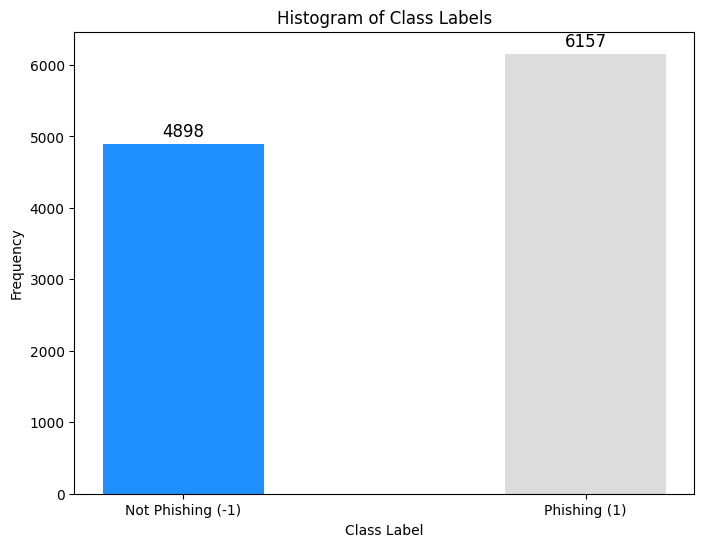

In [5]:
# TO DO: Check the class distribution of y (2 mark)

classes, counts = np.unique(y, return_counts=True)

# Plot the histogram for class labels
plt.figure(figsize=(8, 6))
plt.bar(classes, counts, color=['dodgerblue', 'gainsboro'])

# Annotate each bar with the count
for i, count in enumerate(counts):
    plt.text(classes[i], count + 50, str(count), ha='center', va='bottom', fontsize=12)

plt.title("Histogram of Class Labels")
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.xticks(classes, ["Not Phishing (-1)", "Phishing (1)"])
plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [6]:
from sklearn.model_selection import train_test_split

# TO DO: Create a smaller dataset with 3% of the data
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42)

# TO DO: display sizes of X_small and y_small (2 mark)
print(X_small.shape)
print(y_small.shape)

(331, 30)
(331, 1)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information



### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set


In [ ]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [ ]:
# TO DO: Print classification report (2 marks)


### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---